# Age Inference using ChronoFlow

_To use this model, the *zuko* and *PyTorch* libraries must be installed. Refer to the README for more information._

### 1. Loading the model

First we import all of the necessary dependencies. For this tutorial, in addition to the pre-requisites listed in the main README file, we use ```scipy.special``` to help with the convolution of distributions.

In [ ]:
import sys
sys.path.append('/Users/philvanlane/Documents/chronoflow/chronoflow')

import numpy as np
import zuko
import matplotlib.pyplot as plt
import torch
import scipy.special as sp
from utils import loadModel


We then use zuko to build the model, using the weights file provided.

In [52]:
model = loadModel('../chronoflow/model_artifacts/weights.pth') # Path to the weights file; update as necessary

### 2. Setting bounds and priors

Our model is loaded. Now, to infer stellar ages, we need to specify the bounds in our parameter space that we want to evaluate our probabilities over. These can be adjusted, however we set these limits as conservative bounds.

In [4]:
bounds_logProt = [-1.75,2.5]    # Evaluation bounds in log P_rot
bounds_BPRP0 = [-0.5,5]         # Evaluation bounds in (BP-RP)_0
bounds_logA_Myr = [0,4.14]      # Evaluation bounds in log age (in Myr)

We also set a conditional colour prior as described in Van-Lane et al. (2025), by convolving a uniform colour prior of the expected $(BP-RP)_0$ range with a Gaussian distribution corresponding to the photometric uncertainty.

In [11]:
# Setting uniform colour prior limits
prior_BPRP0_lims = [-0.05,3.8]

# Calculating prior conditioned on colour and photometric uncertaity
def calcColourPrior(C0,sigma_C0,lim_low = prior_BPRP0_lims[0], lim_high = prior_BPRP0_lims[1]):
    """
    Function to calculate the prior on (BP-RP)_0 given a colour and its uncertainty.
    Parameters:
    C0 : float
        The observed de-reddened (BP-RP)_0 value.
    sigma_C0 : float
        The photometric uncertainty of the colour.
    lim_low : float
        The lower limit of the uniform (BP-RP)_0 distribution.
    lim_high : float
        The upper limit of the uniform (BP-RP)_0 distribution.
    Returns:
    prob_val : float
        The probability value of the prior.
    """

    mult_factor = 1 / ((lim_high-lim_low) * (np.sqrt(2 * np.pi * sigma_C0**2)))
    int_const = -np.sqrt(np.pi/2) * sigma_C0
    int_eval = (sp.erf((C0-lim_high)/(sigma_C0 * np.sqrt(2)))) - sp.erf((C0-lim_low)/(sigma_C0 * np.sqrt(2)))
    prob_val = mult_factor * int_const * int_eval
    
    return prob_val

We also use a function to describe our age prior that is uniform over the age of the Universe (in log space).

In [6]:
def calcAgePrior(logA_Myr, lim_low = bounds_logA_Myr[0], lim_high = bounds_logA_Myr[1]):
    """
    Function to calculate the prior on log age (in Myr) given a log age value.
    Parameters:
    logA_Myr : float
        The log age value (in Myr).
    lim_low : float
        The lower limit of the uniform log age distribution.
    lim_high : float
        The upper limit of the uniform log age distribution.
    Returns:
    val : float
        The probability value of the prior.
    """
    prob_val = 1 / (lim_high - lim_low)
    if (logA_Myr < lim_low) | (logA_Myr > lim_high):
        return 0
    else:
        return prob_val

Finally, we need to set the grid granularity of the age range that we are evaluating stellar age posteriors over. Here we use 1000 steps (in log space) over the age of the Universe.

In [7]:
logA_Myr_grid = np.linspace(bounds_logA_Myr[0], bounds_logA_Myr[1], 1000)

### 3. Defining stellar age posterior calculations

First we define a function to calculate the probability of $P_{rot}$ conditioned on age, de-reddened colour, and photometric uncertainty; this is what ChronoFlow models.

In [10]:
def calcLogLikelihood(logA_Myr,
                 BPRP0,
                 logProt,
                 logCerr=-1.55,     # Median log photometric uncertainty across our catalogue
                 P_clmem=1,         
                 P_out=0.05,        
                 model=model,
                 logProt_lims=bounds_logProt,
                ):
    """
    Function to calculate the conditional probability of P_rot given age, colour and photometric uncertainty.
    Parameters:
    logA_Myr : float
        The log age value (in Myr).
    BPRP0 : float
        The (BP-RP)_0 value.
    logProt : float 
        The log P_rot value.
    logCerr : float
        The log photometric uncertainty.
    P_clmem : float
        The probability of the star being a cluster member (this should be set to 1 when analyzing any individual star).
    P_out : float
        The probability of the star not following the anticipated rotational evolution pattern (we default this to 0.05).
    model : zuko.flows.NSF
        The normalizing flow model.
    Returns:
    prob_comb : float
        The conditional probability (as a natural log).
    """
    
    # Calculate weighting of normalizing flow likelihood
    nf_weight = P_clmem * (1 - P_out)
    
    # Use model to evaluate probability
    ind_params = torch.tensor([logA_Myr,BPRP0,logCerr],requires_grad=False).to(torch.float32)
    cond_params = torch.tensor([logProt],requires_grad=False).to(torch.float32)
    nf_prob = model(ind_params).log_prob(cond_params).detach().numpy().item()
    
    # Background (ie. non-cluster member) probability
    bg_prob = np.log(1/(logProt_lims[1] - logProt_lims[0]))
    
    # Combine flow probability and background probability
    prob_val = sp.logsumexp([nf_prob,bg_prob],b=[nf_weight,1-nf_weight])

    return prob_val

We now define a function to generate a posterior probability distribution over an age grid, given some observed data.

In [ ]:

def calcPostAge(logProt,
                BPRP0,
                logCerr=-1.55,
                P_clmem=1,
                P_out=0.05,
                model=model,
                logA_Myr_grid=logA_Myr_grid,
                summary=False
                ):

    """
    Function to calculate the posterior probability of age given P_rot, colour and photometric uncertainty.
    Parameters:
    logProt : float
        The log P_rot value.
    BPRP0 : float
        The (BP-RP)_0 value.
    logCerr : float
        The log photometric uncertainty.
    P_clmem : float
        The probability of the star being a cluster member (this should be set to 1 when analyzing any individual star).
    P_out : float
        The probability of the star not following the anticipated rotational evolution pattern (we default this to 0.05).
    model : zuko.flows.NSF
        The normalizing flow model.
    logA_Myr_grid : np.ndarray
        The grid of log ages (in Myr) to evaluate the posterior probability.
    Returns:
    post : np.ndarray
        The posterior probability distribution of age.
    medLogA : float
        The median log age value (in yr).
    logA_Err : float
        The upper 1 sigma error on the log age value.
    logA_err : float
        The lower 1 sigma error on the log age value.
    """

    logLikelihood = np.zeros(len(logA_Myr_grid))
    logColourPrior = np.zeros(len(logA_Myr_grid))
    logAgePrior = np.zeros(len(logA_Myr_grid))
    logPost = np.zeros(len(logA_Myr_grid))

    for i in range(len(logA_Myr_grid)):

        # Log likelihood probability
        logLikelihood[i] = calcLogLikelihood(logA_Myr=logA_Myr_grid[i],
                                             logProt=logProt,
                                              BPRP0=BPRP0,
                                              logCerr=logCerr,
                                              P_clmem=P_clmem,
                                              P_out=P_out,
                                              model=model,
                                              logProt_lims=bounds_logProt)
        
        # Log colour prior probability
        logColourPrior[i] = np.log(calcColourPrior(BPRP0,10**logCerr))

        # Log age prior probability
        logAgePrior[i] = np.log(calcAgePrior(logA_Myr_grid[i]))
        
        # Combine all to get posterior
        logPost[i] = logLikelihood[i] + logColourPrior[i] + logAgePrior[i]

    # Convert to probability and normalize
    post = np.exp(logPost)
    post /= np.trapz(post,logA_Myr_grid)

    return post


We can also define a function to return summary statistics, by sampling from the posterior distribution.

In [45]:
def getAgeSummStats(post,
                    logA_Myr_grid=logA_Myr_grid,
                    n=1000):
    """
    Function to calculate the summary statistics of the posterior probability distribution.
    Parameters:
    post : np.ndarray
        The posterior probability distribution of age.
    n : int
        The number of samples to use for the summary statistics.
    Returns:
    medLogA : float
        The median log age value (in Myr).
    logA_Err : float
        The upper 1 sigma error on the log age value.
    logA_err : float
        The lower 1 sigma error on the log age value.
    """

    # Draw samples
    prob = post / np.sum(post)
    indices = np.random.choice(len(logA_Myr_grid), size=n, p=prob)
    samples = logA_Myr_grid[indices]

    # Get summary stats
    medLogA = np.median(samples)
    p84 = np.percentile(samples, 84)
    p16 = np.percentile(samples, 16)
    logA_Err = p84 - medLogA
    logA_err = p16 - medLogA

    return medLogA, logA_Err, logA_err

### 4. Putting it all together for stellar age inference!

Let's take a random star as an example, having a period of 20 days, a $(BP-RP)_0$ colour of 1.5, and a photometric error on $(BP-RP)_0$ of 0.03.

In [18]:
Prot = 20
BPRP0 = 1.5
Cerr = 0.03

Let's get the full age posterior for this star.

In [46]:
post = calcPostAge(logProt=np.log10(Prot),
                   BPRP0=BPRP0,
                   logCerr=np.log10(Cerr),
                   summary=False)

Getting full posterior...


We can visualize the posterior over ages.

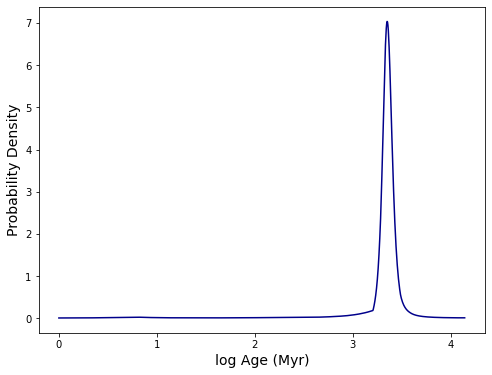

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(logA_Myr_grid, post, label='Posterior', color='darkblue')
plt.xlabel('log Age (Myr)',fontsize=14)
plt.ylabel('Probability Density',fontsize=14)
plt.show()


If we only want to get the estimated age value (along with uncertainties), we can get the summary statistics from the posterior.

In [48]:
medLogA, logA_Err, logA_err = getAgeSummStats(post=post,
                                               logA_Myr_grid=logA_Myr_grid)

print(f'Inferred log age (Myr): {medLogA:.2f} +{logA_Err:.2f} -{-logA_err:.2f}')

Inferred log age (Myr): 3.35 +0.06 -0.07
